In [92]:
# import packages

import matplotlib.pyplot as plt
import numpy as np
from lacbox.io import load_pwr, load_oper
from pathlib import Path
from our_values import *
import pandas as pd
from lacbox.io import load_ctrl_txt
from scipy.optimize import curve_fit
from lacbox.io import ReadHAWC2
from lacbox.test import test_data_path

plt.rcParams.update({'font.family': 'serif', 'font.size':16})
from matplotlib.ticker import FormatStrFormatter



## DTU 10MW

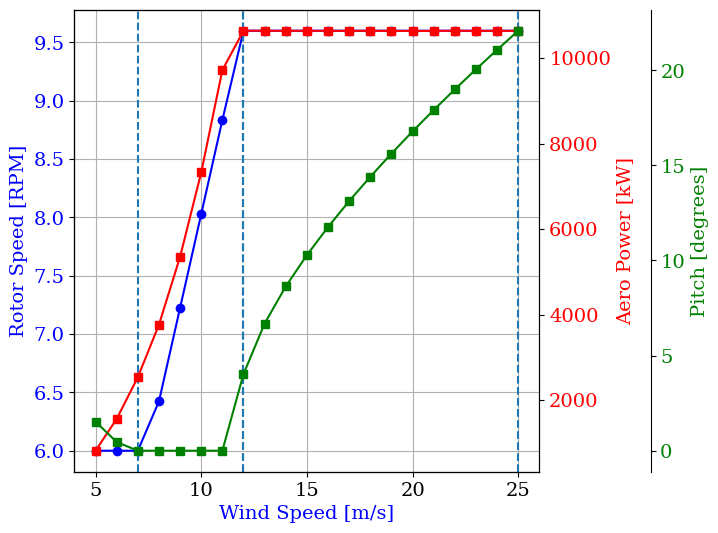

In [2]:
# evaluate regions for dtu 10 MW following lecture 6

dtu_path = 'dtu_10mw/res_hawc2s/dtu_10mw_hawc2s_21wsp_ctrltune.pwr'
dtu_data = load_pwr(dtu_path)
#print(dtu_data.keys())

#regions = [2,3,5,13]        # from lecture, does not make sense
regions = [3,8,8,21]        # from detected regions, in log file

fig, ax1 = plt.subplots(figsize=(6, 6))

# Plot wind speed vs rotor speed
ax1.plot(dtu_data['V_ms'], dtu_data['Speed_rpm'],  'b-o', label='Rotor Speed [RPM]')
ax1.set_ylabel('Rotor Speed [RPM]', color='b')
ax1.set_xlabel('Wind Speed [m/s]', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for aerodynamic power
ax2 = ax1.twinx()
ax2.plot(dtu_data['V_ms'], dtu_data['P_kW'], 'r-s', label='Aero Power [kW]')
ax2.set_ylabel('Aero Power [kW]', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Create a second y-axis for aerodynamic power
ax3 = ax1.twinx()
ax3.plot(dtu_data['V_ms'], dtu_data['Pitch_deg'], 'g-s', label='Pitch [degrees]')
ax3.set_ylabel('Pitch [degrees]', color='g')
ax3.tick_params(axis='y', labelcolor='g')
ax3.spines['right'].set_position(('outward', 80))  # Offset by 120 points

# add regions
for i in regions:
    ax1.axvline(x=dtu_data['V_ms'][i-1], linestyle='--')

ax1.grid(True)

plt.savefig('3_1_dtu10mw_control.pdf', format='pdf',bbox_inches='tight')
plt.show()




## REDESIGN

minimum omega = 2.9985 ≈ 3.0 rpm


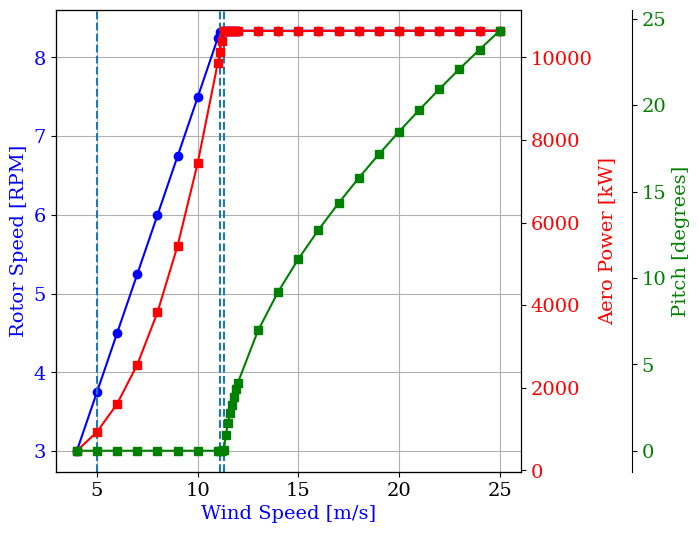

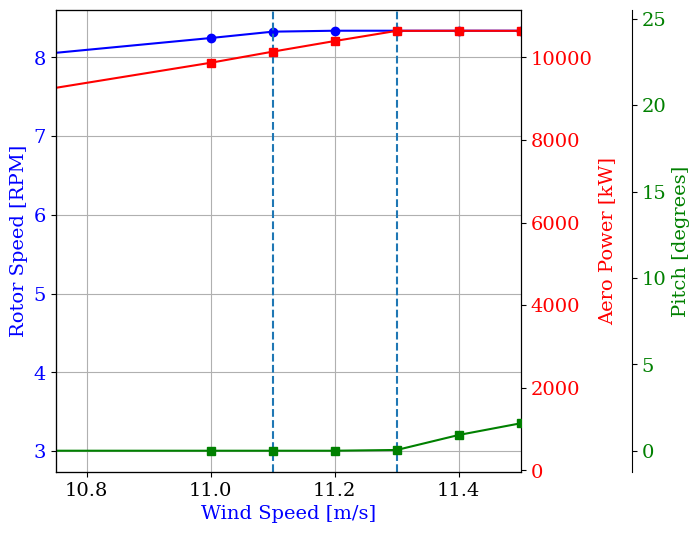

In [3]:
# compute omega minimum to insert in the htc file
V_start = 4
omega_start = TSR_OPT*V_start / R_Y*30/np.pi
print(f'minimum omega = {omega_start:.4f} ≈ {np.round(omega_start,1)} rpm')


# evaluate regions
redesign_path = 'our_design/res_hawc2s/Group1_redesign_hawc2s_ctrltune.pwr'
redesign_data = load_pwr(redesign_path)
#print(dtu_data.keys())

#regions = [2,3,5,13]        # from lecture, does not make sense
regions = [1,8,10,31]        # from detected regions, in log file

fig, ax1 = plt.subplots(figsize=(6, 6))

# Plot wind speed vs rotor speed
ax1.plot(redesign_data['V_ms'], redesign_data['Speed_rpm'],  'b-o', label='Rotor Speed [RPM]')
ax1.set_ylabel('Rotor Speed [RPM]', color='b')
ax1.set_xlabel('Wind Speed [m/s]', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for aerodynamic power
ax2 = ax1.twinx()
ax2.plot(redesign_data['V_ms'], redesign_data['P_kW'], 'r-s', label='Aero Power [kW]')
ax2.set_ylabel('Aero Power [kW]', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Create a second y-axis for aerodynamic power
ax3 = ax1.twinx()
ax3.plot(redesign_data['V_ms'], redesign_data['Pitch_deg'], 'g-s', label='Pitch [degrees]')
ax3.set_ylabel('Pitch [degrees]', color='g')
ax3.tick_params(axis='y', labelcolor='g')
ax3.spines['right'].set_position(('outward', 80))  # Offset by 120 points

# add regions
for i in regions[:-1]:
    ax1.axvline(x=redesign_data['V_ms'][i], linestyle='--')

ax1.grid(True)
plt.savefig('3_1_redesign_control.pdf', format='pdf',bbox_inches='tight')
plt.show()


fig, ax1 = plt.subplots(figsize=(6, 6))

# Plot wind speed vs rotor speed
ax1.plot(redesign_data['V_ms'], redesign_data['Speed_rpm'],  'b-o', label='Rotor Speed [RPM]')
ax1.set_ylabel('Rotor Speed [RPM]', color='b')
ax1.set_xlabel('Wind Speed [m/s]', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for aerodynamic power
ax2 = ax1.twinx()
ax2.plot(redesign_data['V_ms'], redesign_data['P_kW'], 'r-s', label='Aero Power [kW]')
ax2.set_ylabel('Aero Power [kW]', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Create a second y-axis for aerodynamic power
ax3 = ax1.twinx()
ax3.plot(redesign_data['V_ms'], redesign_data['Pitch_deg'], 'g-s', label='Pitch [degrees]')
ax3.set_ylabel('Pitch [degrees]', color='g')
ax3.tick_params(axis='y', labelcolor='g')
ax3.spines['right'].set_position(('outward', 80))  # Offset by 120 points

# add regions
for i in regions[:-1]:
    ax1.axvline(x=redesign_data['V_ms'][i], linestyle='--')

ax1.set_xlim(10.75,11.5)
ax1.grid(True)
plt.savefig('3_1_redesign_control_zoom.pdf', format='pdf',bbox_inches='tight')
plt.show()



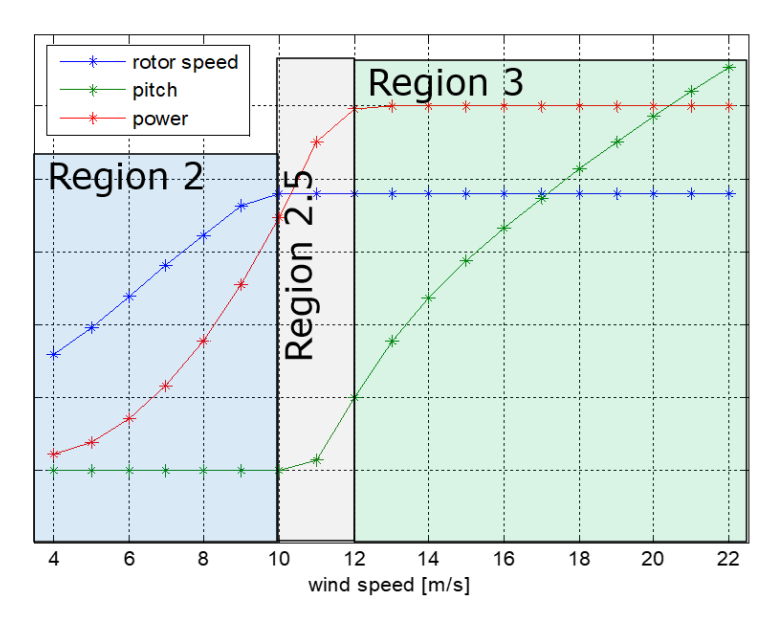

In [114]:
# hawc2s values

def load_ctrl_tuning(file_path):
    with open(file_path, 'r') as file:
        file_content = file.read()

    # Split the file content into lines
    lines = file_content.splitlines()

    # Initialize the dictionary with predefined keys
    data_dict = {
        "K_opt": None,
        "I": None,
        "Kp_torque": None,
        "Ki_torque": None,
        "Kp_pitch": None,
        "Ki_pitch": None,
        "KK1": None,
        "KK2": None,
        "dQ_dtheta_0": None
    }

    # Manually assign values based on line positions
    data_dict["K_opt"] = float(lines[1].split('=')[1].split()[0])
    data_dict["I"] = float(lines[3].split('=')[1].split()[0])
    data_dict["Kp_torque"] = float(lines[4].split('=')[1].split()[0])
    data_dict["Ki_torque"] = float(lines[5].split('=')[1].split()[0])
    data_dict["Kp_pitch"] = float(lines[7].split('=')[1].split()[0])
    data_dict["Ki_pitch"] = float(lines[8].split('=')[1].split()[0])
    data_dict["KK1"] = float(lines[9].split('=')[1].split()[0])
    data_dict["KK2"] = float(lines[9].split('=')[2].split()[0])
    data_dict["dQ_dtheta_0"] = float(lines[9].split('=')[3].split()[0])

    #data_dict["dQ_dtheta_0"] = np.rad2deg(data_dict["dQ_dtheta_0"])*1e3



    fit = pd.read_csv(file_path, sep='\\s+', skiprows=17, header=None)
    fit.columns = ['theta', 'dq_dtheta', 'fit_theta', 'dq_domega', 'fit_omega']

    return data_dict, fit

redesign_ctrl_tuning_path = 'our_design/res_hawc2s/Group1_redesign_hawc2s_ctrltune_ctrl_tuning.txt'
hawc2s_data,  fit_redesign= load_ctrl_tuning(redesign_ctrl_tuning_path)


# theoretical values

def fit_curve_KK(fit_redesign):

    theta = fit_redesign['theta']
    dQdtheta = fit_redesign['dq_dtheta']  # Replace with your actual y data
    c = hawc2s_data["dQ_dtheta_0"]

    # Fit the model to the data
    def model(x, K1, K2):
        return c * (1 + x/K1 + (x**2)/K2)

    initial_guess = [1, 1]  # Initial guess for K1 and K2
    params, covariance = curve_fit(model, theta, dQdtheta, p0=initial_guess)

    # Extract the optimal values of K1 and K2
    KK1, KK2 = params
    dQdtheta_fit =  model(theta, KK1, KK2)

    return KK1, KK2, dQdtheta_fit

def compute_ctrl_tuning(hawc2s_data, fit_redesign):

    eta = 1
    I_r = 1         # rotor inertia, what is the value?
    I_g = 1         # equivalent generator inertia, what is the value?
    n_g = 1         # gear box ratio
    I = I_r + n_g**2 * I_g
    I = hawc2s_data['I']

    # region 2: optinmal CP tracking
    K_opt = eta * RHO * np.pi * R_Y**5 * CP_MAX / (2 * TSR_OPT**3)

    # region 2.5: rotor speed regulation
    omega_speed_torque = 0.05*2*np.pi
    zeta_speed_torque = 0.7
    Kp_torque = 2 * eta * zeta_speed_torque * omega_speed_torque * I
    Ki_torque = eta * I * omega_speed_torque**2

    # region 3:
    omega_speed_pitch = 0.06*2*np.pi
    zeta_speed_pitch = 0.7
    KK1, KK2, dQdtheta_fit = fit_curve_KK(fit_redesign)
    dQ_dtheta_0 = np.rad2deg(hawc2s_data['dQ_dtheta_0'])*1e3     # ???

    dQ_dtheta = dQ_dtheta_0
    dQg_domega = POWER_MAX / ((OMEGA_MAX*2*np.pi/60)**2)

    Kp_pitch = (2 * zeta_speed_pitch * omega_speed_pitch * I + 1/eta *dQg_domega) / (-dQ_dtheta)
    Ki_pitch = (omega_speed_pitch**2 * I) / (- dQ_dtheta)
    
    # K_P_P = -(2*(I)*omega_P*zeta+Power/rot_speed**2)/dqdtheta
    
    dQ_dtheta_0  = np.deg2rad(dQ_dtheta_0/1e3)
    th_data = {
            "K_opt": K_opt,
            "I": I,
            "Kp_torque": Kp_torque,
            "Ki_torque": Ki_torque,
            "Kp_pitch": Kp_pitch,
            "Ki_pitch": Ki_pitch,
            "KK1": KK1,
            "KK2": KK2,
            "dQ_dtheta_0": dQ_dtheta_0
        }
    
    return th_data

th_data = compute_ctrl_tuning(hawc2s_data, fit_redesign)


# comparison
print(f'element     |   theoretical   |      hawc2s     | % difference ')
for key in th_data.keys():
    print(f"{key:12}| {th_data[key]:15.4f} | {hawc2s_data[key]:15.4f} | {(th_data[key] - hawc2s_data[key])/hawc2s_data[key]*100:10.3f}")



element     |   theoretical   |      hawc2s     | % difference 
K_opt       |   15032154.1729 |   15395600.0000 |     -2.361
I           |  192574000.0000 |  192574000.0000 |      0.000
Kp_torque   |   84698468.9141 |   84698600.0000 |     -0.000
Ki_torque   |   19006291.9794 |   19006300.0000 |     -0.000
Kp_pitch    |          1.8249 |          1.8250 |     -0.001
Ki_pitch    |          0.4321 |          0.4321 |     -0.000
KK1         |         13.7800 |         13.7800 |     -0.000
KK2         |        484.8547 |        484.8541 |      0.000
dQ_dtheta_0 |      -1105.4973 |      -1105.4973 |     -0.000


In [5]:
OMEGA_MAX
0.8731395227123424

0.8731395227123424

Fitted K1: 13.779986042012013
Fitted K2: 484.8546700184538


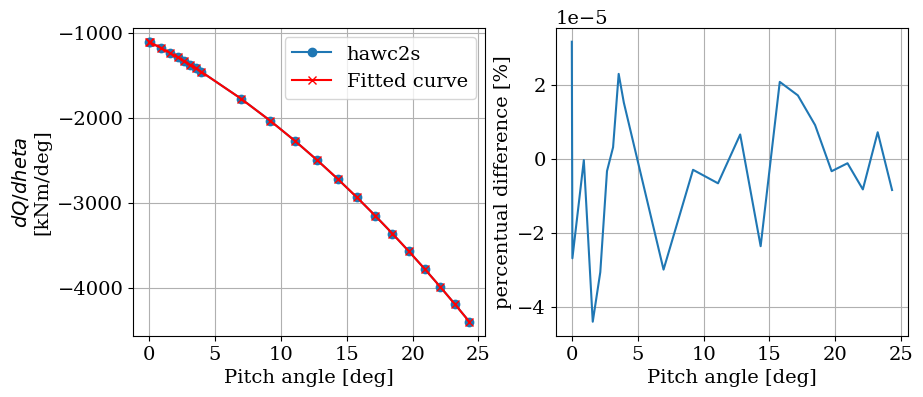

In [6]:
# analyitical derivations

ctrltune_dict = load_ctrl_txt(redesign_ctrl_tuning_path)
hawc2s_data,  fit_redesign= load_ctrl_tuning(redesign_ctrl_tuning_path)
aero_gains_df = ctrltune_dict['aero_gains']

KK1, KK2, dQdtheta_fit = fit_curve_KK(fit_redesign)


# Print the fitted parameters
print(f"Fitted K1: {KK1}")
print(f"Fitted K2: {KK2}")

# Plot the original data and the fitted curve
fig1, axs1 = plt.subplots(1, 2, num=1, figsize=(10,4), clear=True) 
axs1[0].plot(fit_redesign['theta'], fit_redesign['fit_theta'], marker='o', label='hawc2s')
axs1[0].plot(fit_redesign['theta'], dQdtheta_fit, label='Fitted curve', marker='x', color='red')
axs1[0].legend()
axs1[0].grid()
axs1[0].set_xlabel('Pitch angle [deg]')
axs1[0].set_ylabel('$dQ/d\theta$\n[kNm/deg]')

axs1[1].plot(fit_redesign['theta'], (fit_redesign['fit_theta'] - dQdtheta_fit)/fit_redesign['fit_theta']*100)
axs1[1].grid()
axs1[1].set_xlabel('Pitch angle [deg]')
axs1[1].set_ylabel('percentual difference [%]')
plt.savefig('3_1_fit.pdf', format='pdf',bbox_inches='tight')
plt.show()



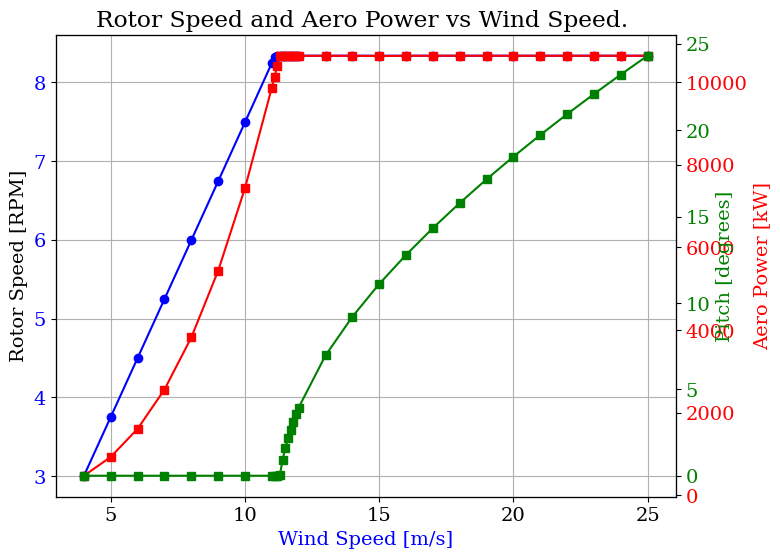

In [7]:

data = load_oper("our_design/data/Group1_redesign_flex.opt")

wind_speed =data['ws_ms']#[i for i in range(len(data['ws_ms']))]
rotor_speed = data['rotor_speed_rpm']
aero_power = data['power_kw']
pitch = data['pitch_deg']
# Create the plot with a secondary y-axis for power
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot wind speed vs rotor speed
ax1.plot(wind_speed, rotor_speed,  'b-o', label='Rotor Speed [RPM]')
ax1.set_ylabel('Rotor Speed [RPM]')
ax1.set_xlabel('Wind Speed [m/s]', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for aerodynamic power
ax2 = ax1.twinx()
ax2.plot(wind_speed, aero_power, 'r-s', label='Aero Power [kW]')
ax2.set_ylabel('Aero Power [kW]', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Create a second y-axis for aerodynamic power
ax3 = ax1.twinx()
ax3.plot(wind_speed, pitch, 'g-s', label='Pitch [degrees]')
ax3.set_ylabel('Pitch [degrees]', color='g')
ax3.tick_params(axis='y', labelcolor='g')

# Add grid and titles
plt.title('Rotor Speed and Aero Power vs Wind Speed. ')
ax1.grid(True)

plt.show()



In [8]:
rho = 1.225
R = 92.52423873284587
CP_max = 0.4414323017299089
lambda_opt = 7.2631578947368425
eta = 1
Power = 10638.3E+03
V = 11.122788574520852 #m/s
rot_speed = lambda_opt/R*V
omega_T = 0.05*2*np.pi

omega_P = 0.06*2*np.pi

zeta = 0.7

#Taken from the dtu_10mw_hawc2s_ctrl_ctrl_tuning.txt
"""WE MIGHT HAVE TO CHANGE THOSE VALUES"""
I = 0.161050E+09
dqdtheta = -1044.85156E+03*180/(np.pi)

K_opt = (eta * rho * np.pi * R**5 * CP_max / (2 * lambda_opt**3))


K_I_T = eta*(I)*omega_T**2

K_P_T = eta*(2*(I)*omega_T*zeta)

K_I_P = -(I)*omega_P**2/dqdtheta

K_P_P = -(2*(I)*omega_P*zeta+Power/rot_speed**2)/dqdtheta

print(K_opt, K_P_T, K_I_T, K_P_P, K_I_P)
print(rot_speed)

15032154.17367775 70833489.56048906 15894997.88795441 1.6529428050185775 0.3823364811255895
0.8731395227123424


## PART 2

In [118]:
print(f'file name  |  Kp       |  Ki ')

for i in range(0,10):
    path = f'our_design/res_hawc2s/Group1_redesign_hawc2s_ctrl_C{i+1}_ctrl_tuning.txt'
    data,  fit= load_ctrl_tuning(path)

    print(f'    C{i+1:2.0f}    | {data["Kp_pitch"]:8.6f} | {data["Ki_pitch"]:8.6f}')


file name  |  Kp       |  Ki 
    C 1    | 1.522750 | 0.293368
    C 2    | 0.476877 | 0.011735
    C 3    | 2.830100 | 1.173470
    C 4    | 1.307350 | 0.293368
    C 5    | 0.261469 | 0.011735
    C 6    | 2.614690 | 1.173470
    C 7    | 1.784220 | 0.422450
    C 8    | 1.261290 | 0.187755
    C 9    | 1.709520 | 0.293368
    C10    | 1.429370 | 0.293368


In [ ]:
file name  |  Kp       |  Ki 
    C 1    | 1.522750 | 2.933680
    C 2    | 0.476877 | 0.117347
    C 3    | 2.830100 | 11.734700
    C 4    | 1.307350 | 2.933680
    C 5    | 0.261469 | 0.117347
    C 6    | 2.614690 | 11.734700
    C 7    | 1.784220 | 4.224500
    C 8    | 1.261290 | 1.877550
    C 9    | 1.709520 | 2.933680
    C10    | 1.429370 | 2.933680

## PART 3

In [10]:
#path = f'our_design/res_hawc2s/Group1_redesign_hawc2s_ctrl_C1_ctrl_tuning.txt'
#ctrltune_dict = load_ctrl_txt(path)

fname = f'our_design/res/Group1_redesign_hawc2s_step_C1.hdf5'
h2res = ReadHAWC2(fname)

names, units, desc = h2res.chaninfo
print('There are', len(names), 'channels in this output file.')
print(names)

idx_power = np.where(['DLL inp   2:   2' in name for name in names])[0]

There are 113 channels in this output file.
['Time', 'bea1 angle', 'bea1 angle_speed', 'bea2 angle', 'bea2 angle_speed', 'bea2 angle', 'bea2 angle_speed', 'bea2 angle', 'bea2 angle_speed', 'Omega', 'Ae rot. torque', 'Ae rot. power', 'Ae rot. thrust', 'WSP gl. coo.,Vx', 'WSP gl. coo.,Vy', 'WSP gl. coo.,Vz', 'WSP gl. coo.,Abs_vhor', 'WSP gl. coo.,Vdir_hor', 'Mx coo: tower', 'My coo: tower', 'Mz coo: tower', 'Mx coo: tower', 'My coo: tower', 'Mz coo: tower', 'Mx coo: shaft', 'My coo: shaft', 'Mz coo: shaft', 'Mx coo: hub1', 'My coo: hub1', 'Mz coo: hub1', 'Mx coo: hub2', 'My coo: hub2', 'Mz coo: hub2', 'Mx coo: hub3', 'My coo: hub3', 'Mz coo: hub3', 'Mx coo: blade1', 'My coo: blade1', 'Mz coo: blade1', 'Mx coo: blade2', 'My coo: blade2', 'Mz coo: blade2', 'Mx coo: blade3', 'My coo: blade3', 'Mz coo: blade3', 'Mx coo: hub1', 'My coo: hub1', 'Mz coo: hub1', 'State pos x  coo: global', 'State pos y  coo: global', 'State acc x  coo: global', 'State acc y  coo: global', 'State pos x  coo: blad

DLL :  2 inpvec :   2  pelec [w]
DLL :  2 inpvec :   2  pelec [w]
DLL :  2 inpvec :   2  pelec [w]


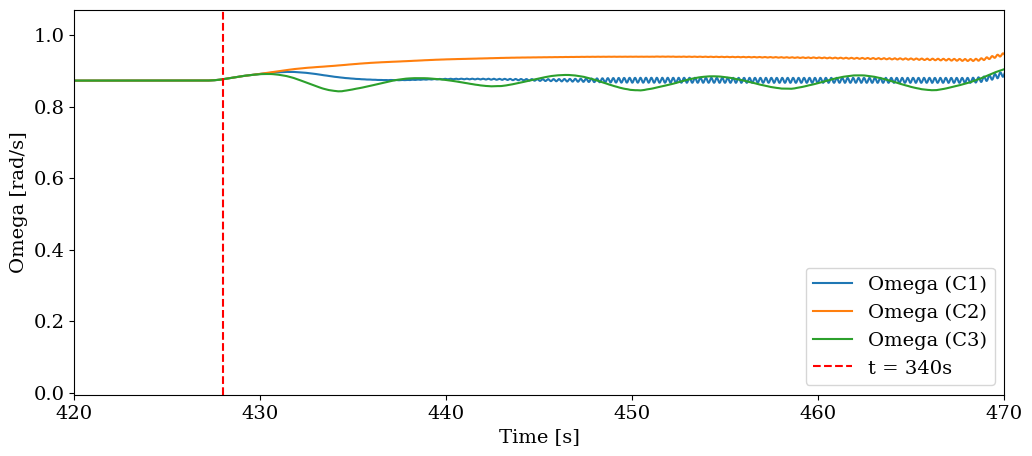

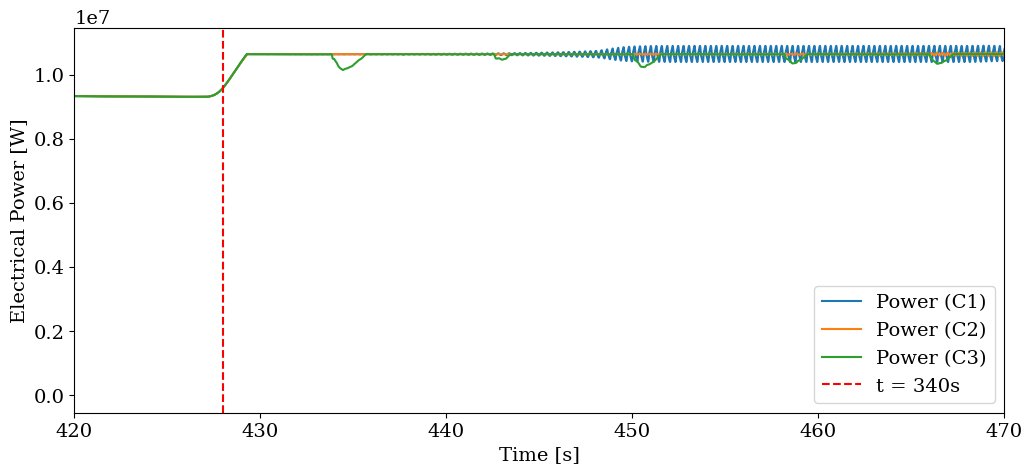

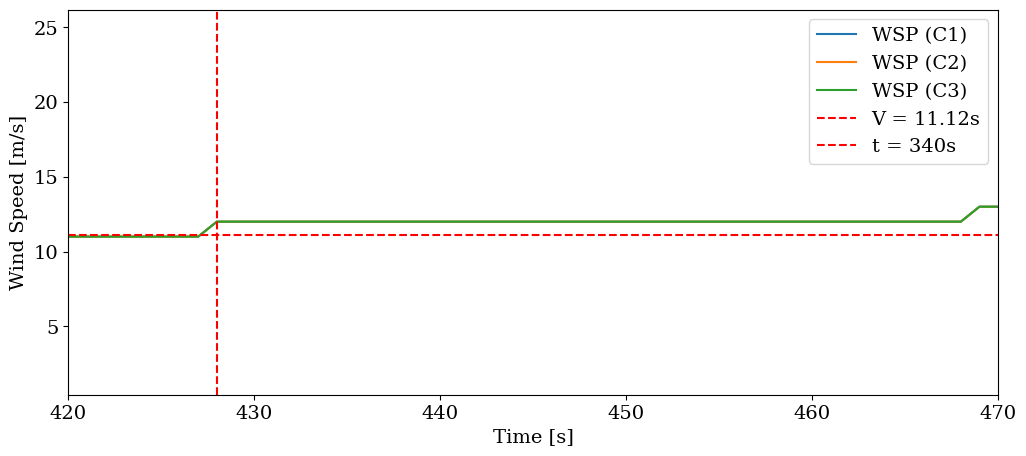

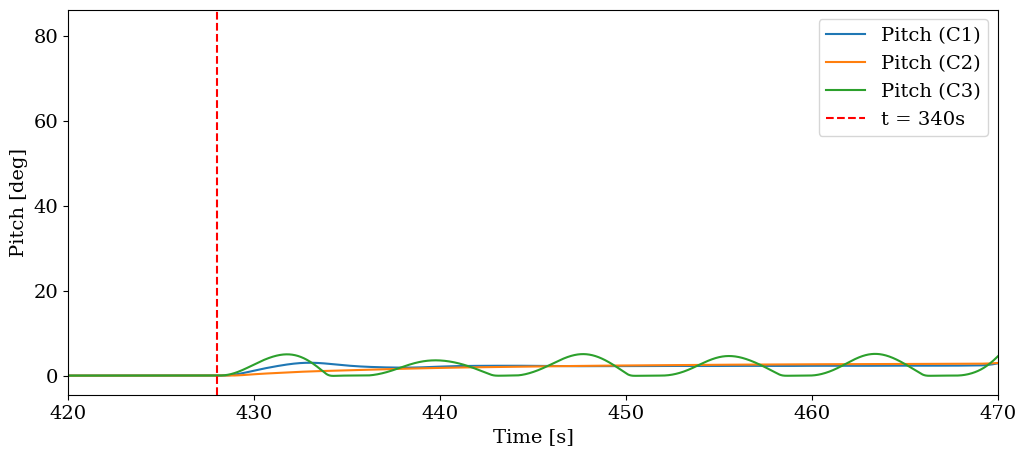

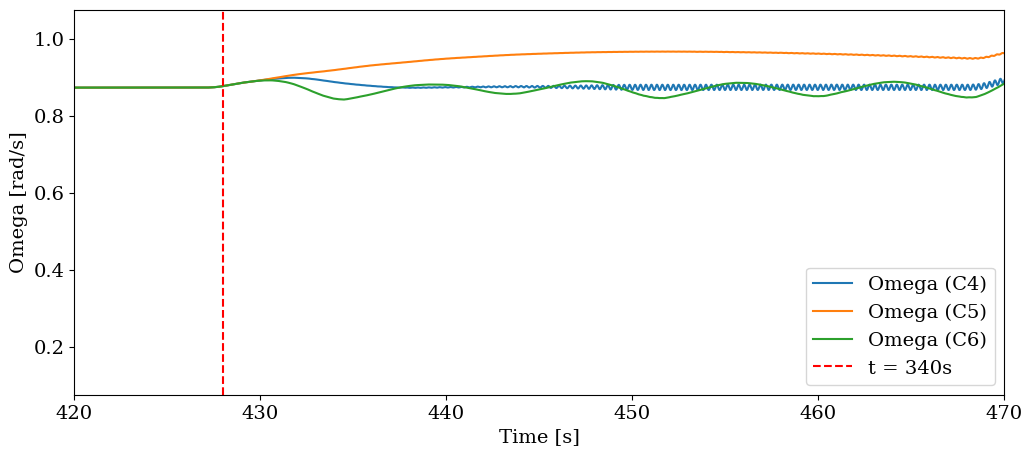

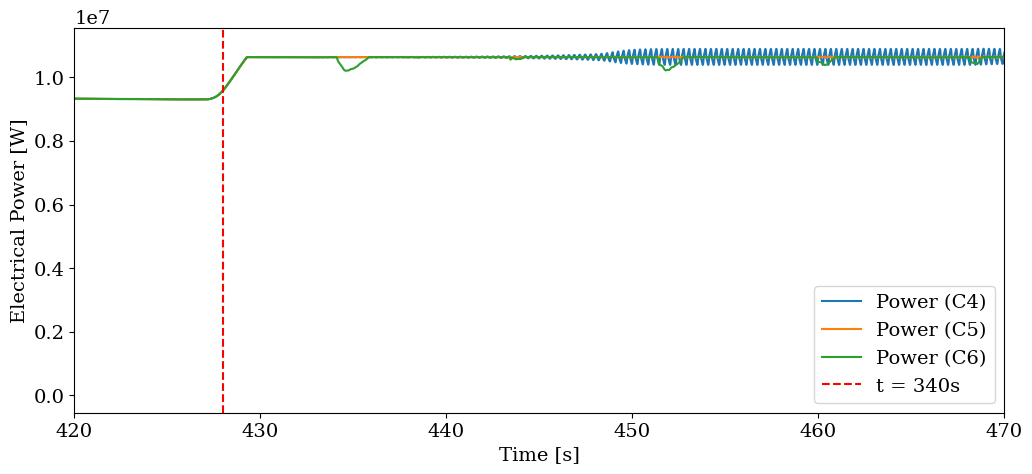

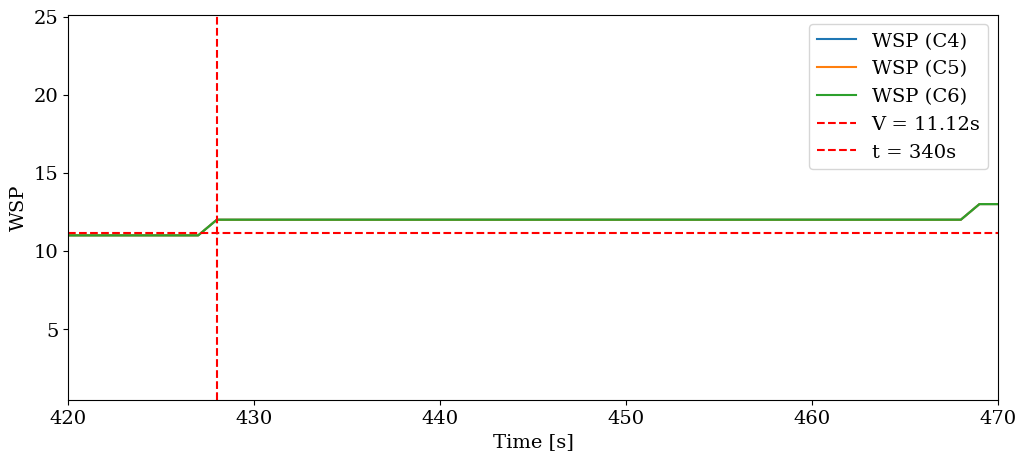

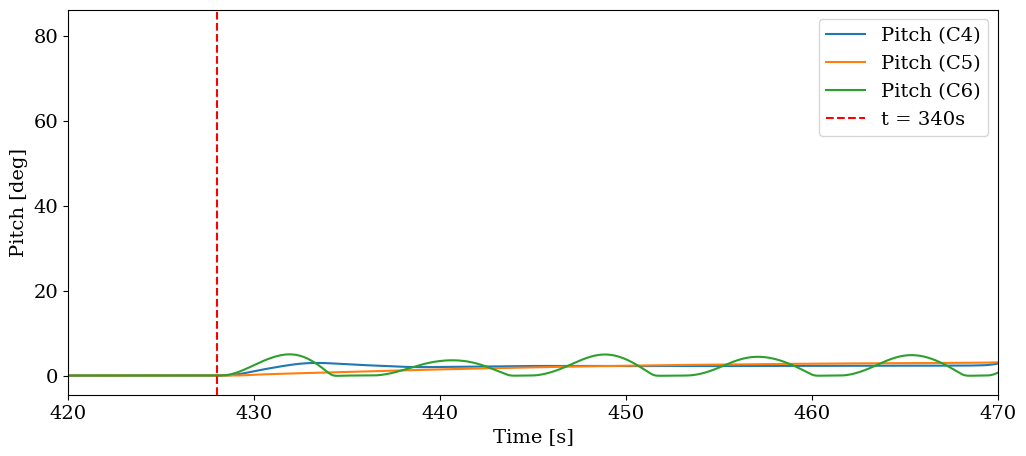

In [11]:
# first plote C1 -- C6

# Define the vertical line position
vertical_line_time = 428
xmin = 420
xmax = 470
horizontal_line_wsp = V_RATED_Y

# Create figure and axes for each variable
fig_omega, ax_omega = plt.subplots(figsize=(12, 5))
fig_power, ax_power = plt.subplots(figsize=(12, 5))
fig_wsp, ax_wsp = plt.subplots(figsize=(12, 5))
fig_pitch, ax_pitch = plt.subplots(figsize=(12, 5))

for k in range(1, 4):
    # Filename for each iteration
    fname = f'our_design/res/Group1_redesign_hawc2s_step_C{k}.hdf5'
    h2res = ReadHAWC2(fname)
    
    # Retrieve channel information
    names, units, desc = h2res.chaninfo

    # Extract indices for time, WSP, Omega, pitch, and power
    idx_Time = np.where(['Time [s]' in name for name in names])[0]
    idx_WSP = np.where(['WSP gl. coo.,Vy' in name for name in names])[0]
    idx_Omega = np.where(['Omega' in name for name in names])[0]
    idx_pitch = np.where(['bea2 angle' in name for name in names])[0]
    idx_power = np.where(['DLL inp   2:   2' in name for name in names])[0]
    [print(desc[i]) for i in idx_power]
    # Plot WSP
    ax_wsp.plot(h2res.t, h2res.data[:, idx_WSP], label=f'WSP (C{k})')
    
    # Plot Pitch
    ax_pitch.plot(h2res.t, h2res.data[:, idx_pitch[0]], label=f'Pitch (C{k})')
    
    # Plot Omega
    ax_omega.plot(h2res.t, h2res.data[:, idx_Omega], label=f'Omega (C{k})')

    # Plot Power
    ax_power.plot(h2res.t, h2res.data[:, idx_power], label=f'Power (C{k})')

# Add vertical line at t = 340s on each plot
ax_wsp.axhline(y=horizontal_line_wsp, color='red', linestyle='--', label=f'V = {V_RATED_Y:.2f}s')
ax_wsp.axvline(x=vertical_line_time, color='red', linestyle='--', label='t = 340s')
ax_pitch.axvline(x=vertical_line_time, color='red', linestyle='--', label='t = 340s')
ax_omega.axvline(x=vertical_line_time, color='red', linestyle='--', label='t = 340s')
ax_power.axvline(x=vertical_line_time, color='red', linestyle='--', label='t = 340s')


# Set labels and titles for WSP plot
ax_wsp.set_xlabel('Time [s]')
ax_wsp.set_ylabel('Wind Speed [m/s]')
ax_wsp.set(xlim=[xmin, xmax])
ax_wsp.legend()

# Set labels and titles for Pitch plot
ax_pitch.set_xlabel('Time [s]')
ax_pitch.set_ylabel('Pitch [deg]')
ax_pitch.set(xlim=[xmin, xmax])
ax_pitch.legend()

# Set labels and titles for Omega plot
ax_omega.set_xlabel('Time [s]')
ax_omega.set_ylabel('Omega [rad/s]')
ax_omega.set(xlim=[xmin, xmax])
ax_omega.legend()

# Set labels and titles for Power plot
ax_power.set_xlabel('Time [s]')
ax_power.set_ylabel('Electrical Power [W]')
ax_power.set(xlim=[xmin, xmax])
ax_power.legend()

# Save each figure to a file
fig_omega.savefig('omega_plot_123.pdf')  # Save Omega plot
fig_power.savefig('power_plot_123.pdf')  # Save Power plot
fig_wsp.savefig('wsp_plot_123.pdf')      # Save WSP plot
fig_pitch.savefig('pitch_plot_123.png')  # Save Pitch plot

# Show all plots
plt.show()

# Create figure and axes for each variable
fig_omega, ax_omega = plt.subplots(figsize=(12, 5))
fig_power, ax_power = plt.subplots(figsize=(12, 5))
fig_wsp, ax_wsp = plt.subplots(figsize=(12, 5))
fig_pitch, ax_pitch = plt.subplots(figsize=(12, 5))

for k in range(4, 7):
    # Filename for each iteration
    fname = f'our_design/res/Group1_redesign_hawc2s_step_C{k}.hdf5'
    h2res = ReadHAWC2(fname)
    
    # Retrieve channel information
    names, units, desc = h2res.chaninfo

    # Extract indices for time, WSP, Omega, pitch, and power
    idx_Time = np.where(['Time' in name for name in names])[0]
    idx_WSP = np.where(['WSP gl. coo.,Vy' in name for name in names])[0]
    idx_Omega = np.where(['Omega' in name for name in names])[0]
    idx_pitch = np.where(['bea2 angle' in name for name in names])[0]
    idx_power = np.where(['DLL inp   2:   2' in name for name in names])[0]

    # Plot and set Y-limits for each axis
    ax_wsp.plot(h2res.t, h2res.data[:, idx_WSP], label=f'WSP (C{k})')

    ax_pitch.plot(h2res.t, h2res.data[:, idx_pitch[0]], label=f'Pitch (C{k})')

    ax_omega.plot(h2res.t, h2res.data[:, idx_Omega], label=f'Omega (C{k})')

    ax_power.plot(h2res.t, h2res.data[:, idx_power], label=f'Power (C{k})')



# Add vertical line at t = 340s on each plot
ax_wsp.axhline(y=horizontal_line_wsp, color='red', linestyle='--', label=f'V = {V_RATED_Y:.2f}s')
ax_wsp.axvline(x=vertical_line_time, color='red', linestyle='--', label='t = 340s')
ax_pitch.axvline(x=vertical_line_time, color='red', linestyle='--', label='t = 340s')
ax_omega.axvline(x=vertical_line_time, color='red', linestyle='--', label='t = 340s')
ax_power.axvline(x=vertical_line_time, color='red', linestyle='--', label='t = 340s')


# Set labels and titles for WSP plot
ax_wsp.set_xlabel('Time [s]')
ax_wsp.set_ylabel('WSP')
ax_wsp.set(xlim=[xmin, xmax])
ax_wsp.relim() 
ax_wsp.autoscale_view()
ax_wsp.legend()

# Set labels and titles for Pitch plot
ax_pitch.set_xlabel('Time [s]')
ax_pitch.set_ylabel('Pitch [deg]')
ax_pitch.set(xlim=[xmin, xmax])
ax_pitch.relim() 
ax_pitch.autoscale_view() 
ax_pitch.legend()

# Set labels and titles for Omega plot
ax_omega.set_xlabel('Time [s]')
ax_omega.set_ylabel('Omega [rad/s]')
ax_omega.set(xlim=[xmin, xmax])
ax_omega.relim() 
ax_omega.autoscale_view() 
ax_omega.legend()

# Set labels and titles for Power plot
ax_power.set_xlabel('Time [s]')
ax_power.set_ylabel('Electrical Power [W]')
ax_power.set(xlim=[xmin, xmax])
ax_power.relim()  
ax_power.autoscale_view()   
ax_power.legend()

# Save each figure to a file
fig_omega.savefig('omega_plot_456.pdf')  # Save Omega plot
fig_power.savefig('power_plot_456.pdf')  # Save Power plot
fig_wsp.savefig('wsp_plot_456.pdf')      # Save WSP plot
fig_pitch.savefig('pitch_plot_456.png')  # Save Pitch plot

# Show all plots
plt.show()

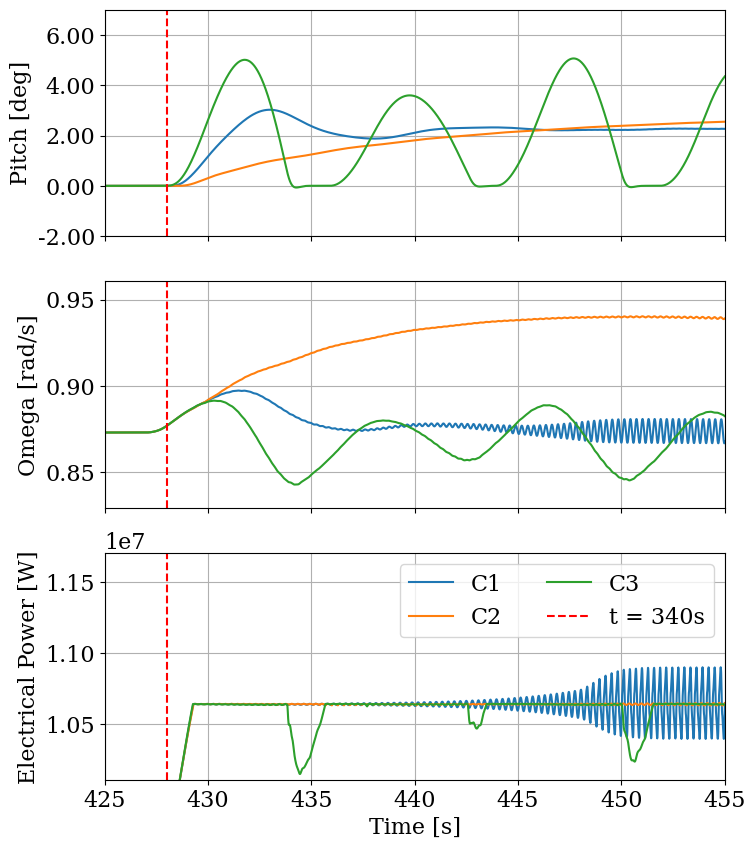

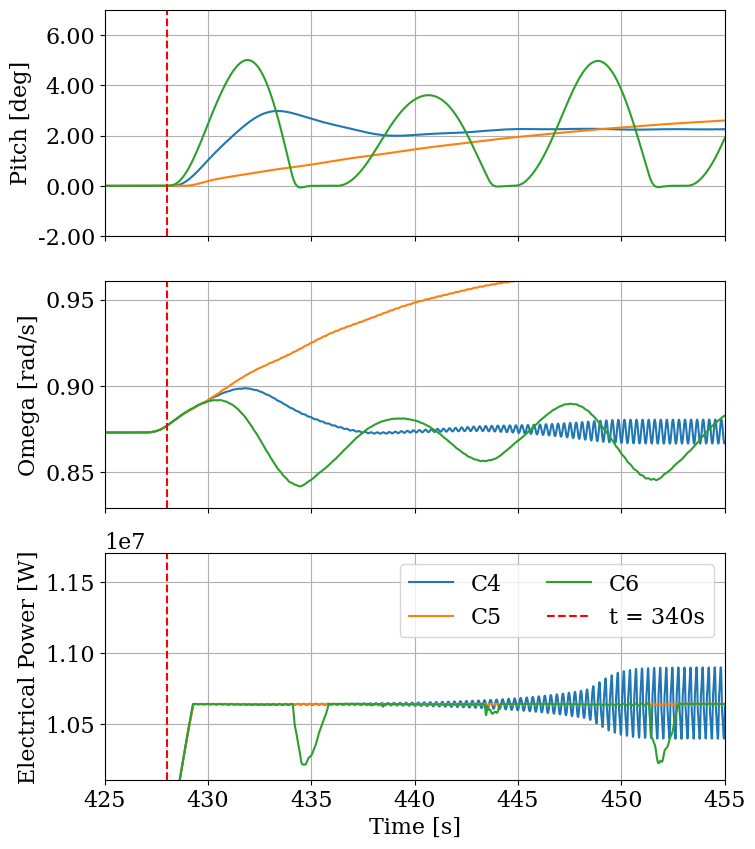

In [96]:
# Define the vertical line position
#xmin = 0
#xmax = 1001
xmin = 425
xmax = 455
vertical_line_time = 428
horizontal_line_wsp = V_RATED_Y

pitch_max = 7
pitch_min = -2
max_coeff = 1.1
min_coeff = 0.95


fig, (ax_pitch, ax_omega, ax_power) = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

# plot the others
for k in range(1, 4):
    # Filename for each iteration
    fname = f'our_design/res/Group1_redesign_hawc2s_step_C{k}.hdf5'
    h2res = ReadHAWC2(fname)
    
    # Retrieve channel information
    names, units, desc = h2res.chaninfo

    # Extract indices for time, WSP, Omega, pitch, and power
    idx_Time = np.where(['Time [s]' in name for name in names])[0]
    idx_Omega = np.where(['Omega' in name for name in names])[0]
    idx_pitch = np.where(['bea2 angle' in name for name in names])[0]
    idx_power = np.where(['DLL inp   2:   2' in name for name in names])[0]

    ax_pitch.plot(h2res.t, h2res.data[:, idx_pitch[0]], label=f'Pitch (C{k})')
    ax_omega.plot(h2res.t, h2res.data[:, idx_Omega], label=f'Omega (C{k})')
    ax_power.plot(h2res.t, h2res.data[:, idx_power], label=f'C{k}')


ax_pitch.axvline(x=vertical_line_time, color='red', linestyle='--', label='t = 340s')
ax_omega.axvline(x=vertical_line_time, color='red', linestyle='--', label='t = 340s')
ax_power.axvline(x=vertical_line_time, color='red', linestyle='--', label='t = 340s')

# Set labels and titles for Pitch plot
ax_pitch.set_ylabel('Pitch [deg]')
ax_pitch.set(xlim=[xmin, xmax])
ax_pitch.set(ylim=[pitch_min, pitch_max])
ax_pitch.yaxis.set_major_formatter(FormatStrFormatter('%3.2f'))  # Set y-ticks to 1 decimal
ax_pitch.grid()
#ax_pitch.legend(ncol=2)

# Set labels and titles for Omega plot
ax_omega.set_ylabel('Omega [rad/s]')
ax_omega.set(xlim=[xmin, xmax])
ax_omega.set(ylim=[OMEGA_MAX*np.pi/30*min_coeff, OMEGA_MAX*np.pi/30*max_coeff])
ax_omega.grid()
#ax_omega.legend(ncol=2)

# Set labels and titles for Power plot
ax_power.set_xlabel('Time [s]')
ax_power.set_ylabel('Electrical Power [W]')
ax_power.set(xlim=[xmin, xmax])
ax_power.set(ylim=[POWER_MAX*min_coeff, POWER_MAX*max_coeff])
ax_power.grid()
ax_power.legend(ncol=2)

# Show all plots
fig.savefig('3_3_123_zoom.pdf', format='pdf',bbox_inches='tight')
plt.show()




fig, (ax_pitch, ax_omega, ax_power) = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

# plot the others
for k in range(4,7):
    # Filename for each iteration
    fname = f'our_design/res/Group1_redesign_hawc2s_step_C{k}.hdf5'
    h2res = ReadHAWC2(fname)
    
    # Retrieve channel information
    names, units, desc = h2res.chaninfo

    # Extract indices for time, WSP, Omega, pitch, and power
    idx_Time = np.where(['Time [s]' in name for name in names])[0]
    idx_Omega = np.where(['Omega' in name for name in names])[0]
    idx_pitch = np.where(['bea2 angle' in name for name in names])[0]
    idx_power = np.where(['DLL inp   2:   2' in name for name in names])[0]

    ax_pitch.plot(h2res.t, h2res.data[:, idx_pitch[0]], label=f'Pitch (C{k})')
    ax_omega.plot(h2res.t, h2res.data[:, idx_Omega], label=f'Omega (C{k})')
    ax_power.plot(h2res.t, h2res.data[:, idx_power], label=f'C{k}')


ax_pitch.axvline(x=vertical_line_time, color='red', linestyle='--', label='t = 340s')
ax_omega.axvline(x=vertical_line_time, color='red', linestyle='--', label='t = 340s')
ax_power.axvline(x=vertical_line_time, color='red', linestyle='--', label='t = 340s')

# Set labels and titles for Pitch plot
ax_pitch.set_ylabel('Pitch [deg]')
ax_pitch.set(xlim=[xmin, xmax])
ax_pitch.set(ylim=[pitch_min, pitch_max])
ax_pitch.yaxis.set_major_formatter(FormatStrFormatter('%3.2f'))  # Set y-ticks to 1 decimal
ax_pitch.grid()
#ax_pitch.legend(ncol=2)

# Set labels and titles for Omega plot
ax_omega.set_ylabel('Omega [rad/s]')
ax_omega.set(xlim=[xmin, xmax])
ax_omega.set(ylim=[OMEGA_MAX*np.pi/30*min_coeff, OMEGA_MAX*np.pi/30*max_coeff])
ax_omega.grid()
#ax_omega.legend(ncol=2)

# Set labels and titles for Power plot
ax_power.set_xlabel('Time [s]')
ax_power.set_ylabel('Electrical Power [W]')
ax_power.set(xlim=[xmin, xmax])
ax_power.set(ylim=[POWER_MAX*min_coeff, POWER_MAX*max_coeff])
ax_power.grid()
ax_power.legend(ncol=2)

# Show all plots
fig.savefig('3_3_456_zoom.pdf', format='pdf',bbox_inches='tight')
plt.show()

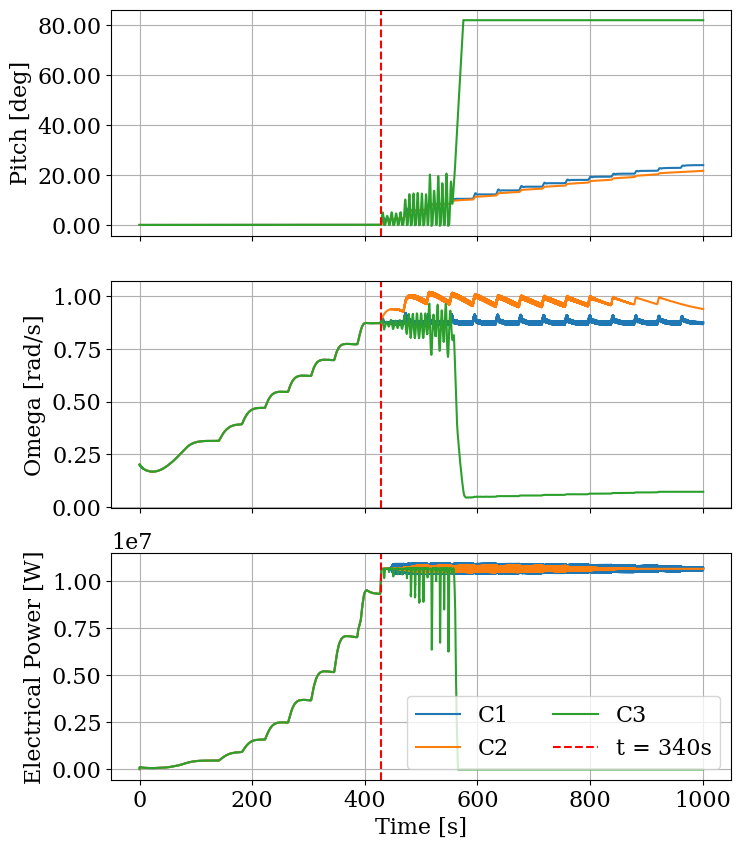

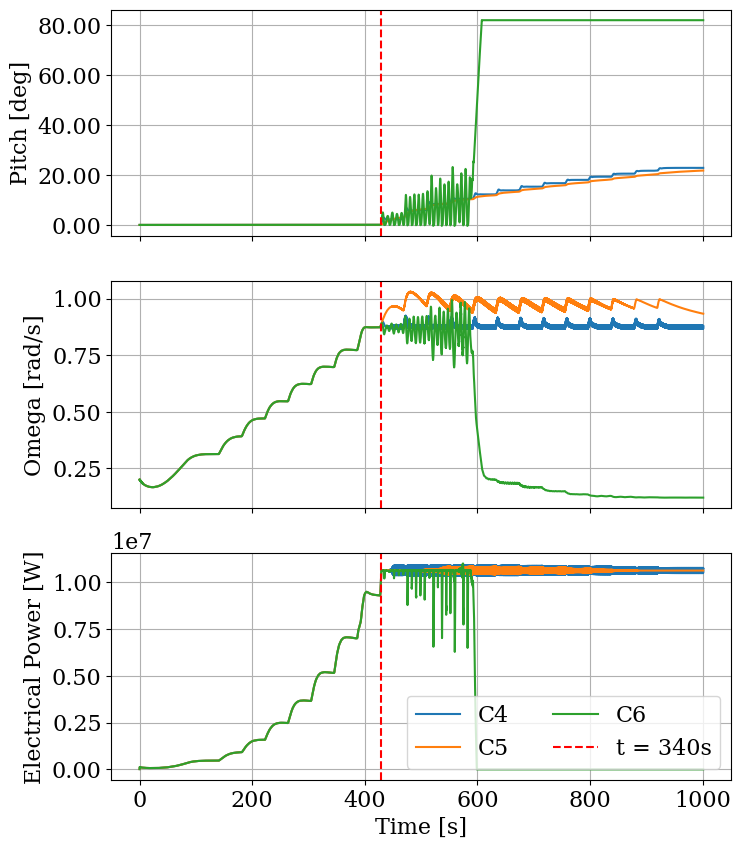

In [97]:
# complete plots

xmin = 0
xmax = 1001

vertical_line_time = 428
horizontal_line_wsp = V_RATED_Y

pitch_max = 7
pitch_min = -2
max_coeff = 1.1
min_coeff = 0.95


fig, (ax_pitch, ax_omega, ax_power) = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

# plot the others
for k in range(1, 4):
    # Filename for each iteration
    fname = f'our_design/res/Group1_redesign_hawc2s_step_C{k}.hdf5'
    h2res = ReadHAWC2(fname)
    
    # Retrieve channel information
    names, units, desc = h2res.chaninfo

    # Extract indices for time, WSP, Omega, pitch, and power
    idx_Time = np.where(['Time [s]' in name for name in names])[0]
    idx_Omega = np.where(['Omega' in name for name in names])[0]
    idx_pitch = np.where(['bea2 angle' in name for name in names])[0]
    idx_power = np.where(['DLL inp   2:   2' in name for name in names])[0]

    ax_pitch.plot(h2res.t, h2res.data[:, idx_pitch[0]], label=f'Pitch (C{k})')
    ax_omega.plot(h2res.t, h2res.data[:, idx_Omega], label=f'Omega (C{k})')
    ax_power.plot(h2res.t, h2res.data[:, idx_power], label=f'C{k}')


ax_pitch.axvline(x=vertical_line_time, color='red', linestyle='--', label='t = 340s')
ax_omega.axvline(x=vertical_line_time, color='red', linestyle='--', label='t = 340s')
ax_power.axvline(x=vertical_line_time, color='red', linestyle='--', label='t = 340s')

# Set labels and titles for Pitch plot
ax_pitch.set_ylabel('Pitch [deg]')
#ax_pitch.set(xlim=[xmin, xmax])
#ax_pitch.set(ylim=[pitch_min, pitch_max])
ax_pitch.yaxis.set_major_formatter(FormatStrFormatter('%3.2f'))  # Set y-ticks to 1 decimal
ax_pitch.grid()
#ax_pitch.legend(ncol=2)

# Set labels and titles for Omega plot
ax_omega.set_ylabel('Omega [rad/s]')
#ax_omega.set(xlim=[xmin, xmax])
#ax_omega.set(ylim=[OMEGA_MAX*np.pi/30*min_coeff, OMEGA_MAX*np.pi/30*max_coeff])
ax_omega.grid()
#ax_omega.legend(ncol=2)

# Set labels and titles for Power plot
ax_power.set_xlabel('Time [s]')
ax_power.set_ylabel('Electrical Power [W]')
#ax_power.set(xlim=[xmin, xmax])
#ax_power.set(ylim=[POWER_MAX*min_coeff, POWER_MAX*max_coeff])
ax_power.grid()
ax_power.legend(ncol=2)

# Show all plots
fig.savefig('3_3_123.pdf', format='pdf',bbox_inches='tight')
plt.show()




fig, (ax_pitch, ax_omega, ax_power) = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

# plot the others
for k in range(4,7):
    # Filename for each iteration
    fname = f'our_design/res/Group1_redesign_hawc2s_step_C{k}.hdf5'
    h2res = ReadHAWC2(fname)
    
    # Retrieve channel information
    names, units, desc = h2res.chaninfo

    # Extract indices for time, WSP, Omega, pitch, and power
    idx_Time = np.where(['Time [s]' in name for name in names])[0]
    idx_Omega = np.where(['Omega' in name for name in names])[0]
    idx_pitch = np.where(['bea2 angle' in name for name in names])[0]
    idx_power = np.where(['DLL inp   2:   2' in name for name in names])[0]

    ax_pitch.plot(h2res.t, h2res.data[:, idx_pitch[0]], label=f'Pitch (C{k})')
    ax_omega.plot(h2res.t, h2res.data[:, idx_Omega], label=f'Omega (C{k})')
    ax_power.plot(h2res.t, h2res.data[:, idx_power], label=f'C{k}')


ax_pitch.axvline(x=vertical_line_time, color='red', linestyle='--', label='t = 340s')
ax_omega.axvline(x=vertical_line_time, color='red', linestyle='--', label='t = 340s')
ax_power.axvline(x=vertical_line_time, color='red', linestyle='--', label='t = 340s')

# Set labels and titles for Pitch plot
ax_pitch.set_ylabel('Pitch [deg]')
#ax_pitch.set(xlim=[xmin, xmax])
#ax_pitch.set(ylim=[pitch_min, pitch_max])
ax_pitch.yaxis.set_major_formatter(FormatStrFormatter('%3.2f'))  # Set y-ticks to 1 decimal
ax_pitch.grid()
#ax_pitch.legend(ncol=2)

# Set labels and titles for Omega plot
ax_omega.set_ylabel('Omega [rad/s]')
#ax_omega.set(xlim=[xmin, xmax])
#ax_omega.set(ylim=[OMEGA_MAX*np.pi/30*min_coeff, OMEGA_MAX*np.pi/30*max_coeff])
ax_omega.grid()
#ax_omega.legend(ncol=2)

# Set labels and titles for Power plot
ax_power.set_xlabel('Time [s]')
ax_power.set_ylabel('Electrical Power [W]')
#ax_power.set(xlim=[xmin, xmax])
#ax_power.set(ylim=[POWER_MAX*min_coeff, POWER_MAX*max_coeff])
ax_power.grid()
ax_power.legend(ncol=2)

# Show all plots
fig.savefig('3_3_456.pdf', format='pdf',bbox_inches='tight')
plt.show()

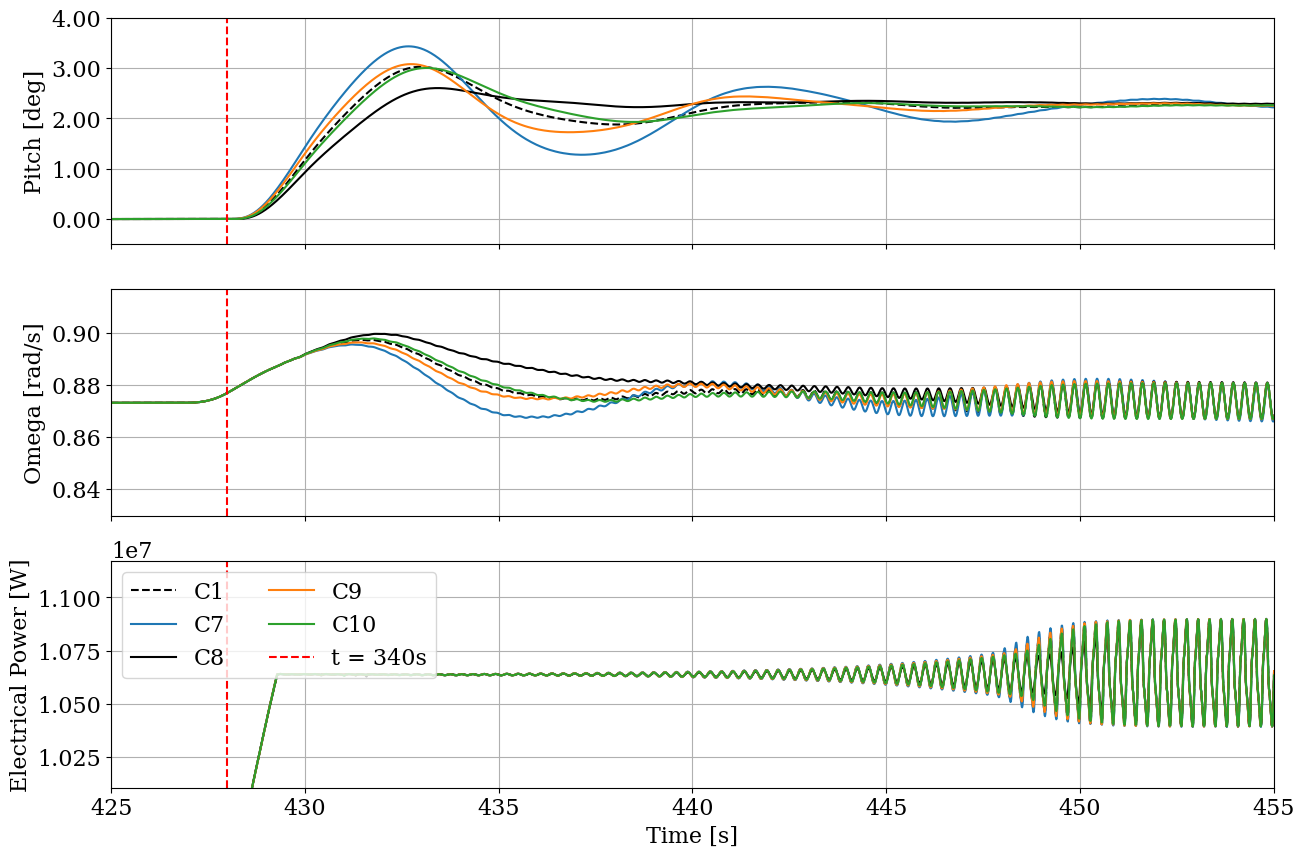

In [113]:
# second plots comparison C1


# Define the vertical line position
#xmin = 0
#xmax = 1001
xmin = 425
xmax = 455
vertical_line_time = 428
horizontal_line_wsp = V_RATED_Y

fig, (ax_pitch, ax_omega, ax_power) = plt.subplots(3, 1, figsize=(15, 10), sharex=True)


# plot k C1
k=1
# Filename for each iteration
fname = f'our_design/res/Group1_redesign_hawc2s_step_C{k}.hdf5'
h2res = ReadHAWC2(fname)

# Retrieve channel information
names, units, desc = h2res.chaninfo

# Extract indices for time, WSP, Omega, pitch, and power
idx_Time = np.where(['Time [s]' in name for name in names])[0]
idx_Omega = np.where(['Omega' in name for name in names])[0]
idx_pitch = np.where(['bea2 angle' in name for name in names])[0]
idx_power = np.where(['DLL inp   2:   2' in name for name in names])[0]

# Plot Pitch
ax_pitch.plot(h2res.t, h2res.data[:, idx_pitch[0]], label=f'Pitch (C{k})', color='k', linestyle='dashed')

# Plot Omega
ax_omega.plot(h2res.t, h2res.data[:, idx_Omega], label=f'Omega (C{k})',color='k',linestyle='dashed')

# Plot Power
ax_power.plot(h2res.t, h2res.data[:, idx_power], label=f'C{k}',color='k', linestyle='dashed')


# plot the others
for k in range(7,11,1):
    # Filename for each iteration
    fname = f'our_design/res/Group1_redesign_hawc2s_step_C{k}.hdf5'
    h2res = ReadHAWC2(fname)
    
    # Retrieve channel information
    names, units, desc = h2res.chaninfo

    # Extract indices for time, WSP, Omega, pitch, and power
    idx_Time = np.where(['Time [s]' in name for name in names])[0]
    idx_Omega = np.where(['Omega' in name for name in names])[0]
    idx_pitch = np.where(['bea2 angle' in name for name in names])[0]
    idx_power = np.where(['DLL inp   2:   2' in name for name in names])[0]

    if k==8:
        ax_pitch.plot(h2res.t, h2res.data[:, idx_pitch[0]], label=f'Pitch (C{k})', color='k')
        ax_omega.plot(h2res.t, h2res.data[:, idx_Omega], label=f'Omega (C{k})', color='k')
        ax_power.plot(h2res.t, h2res.data[:, idx_power], label=f'C{k}', color='k')
    else:
        ax_pitch.plot(h2res.t, h2res.data[:, idx_pitch[0]], label=f'Pitch (C{k})')
        ax_omega.plot(h2res.t, h2res.data[:, idx_Omega], label=f'Omega (C{k})')
        ax_power.plot(h2res.t, h2res.data[:, idx_power], label=f'C{k}')


ax_pitch.axvline(x=vertical_line_time, color='red', linestyle='--', label='t = 340s')
ax_omega.axvline(x=vertical_line_time, color='red', linestyle='--', label='t = 340s')
ax_power.axvline(x=vertical_line_time, color='red', linestyle='--', label='t = 340s')

# Set labels and titles for Pitch plot
ax_pitch.set_ylabel('Pitch [deg]')
ax_pitch.set(xlim=[xmin, xmax])
ax_pitch.set(ylim=[-0.5, 4])
ax_pitch.yaxis.set_major_formatter(FormatStrFormatter('%3.2f'))  # Set y-ticks to 1 decimal
ax_pitch.grid()
#ax_pitch.legend(ncol=2)

# Set labels and titles for Omega plot
ax_omega.set_ylabel('Omega [rad/s]')
ax_omega.set(xlim=[xmin, xmax])
ax_omega.set(ylim=[OMEGA_MAX*np.pi/30*0.95, OMEGA_MAX*np.pi/30*1.05])
ax_omega.grid()
#ax_omega.legend(ncol=2)

# Set labels and titles for Power plot
ax_power.set_xlabel('Time [s]')
ax_power.set_ylabel('Electrical Power [W]')
ax_power.set(xlim=[xmin, xmax])
ax_power.set(ylim=[POWER_MAX*0.95, POWER_MAX*1.05])
ax_power.grid()
ax_power.legend(ncol=2)

# Save each figure to a file
#fig_omega.savefig('omega_plot_17.pdf')  # Save Omega plot
#fig_power.savefig('power_plot_17.pdf')  # Save Power plot
#fig_wsp.savefig('wsp_plot_17.pdf')      # Save WSP plot
#fig_pitch.savefig('pitch_plot_17.png')  # Save Pitch plot

# Show all plots
fig.savefig('3_3_new_controller.pdf', format='pdf',bbox_inches='tight')
plt.show()


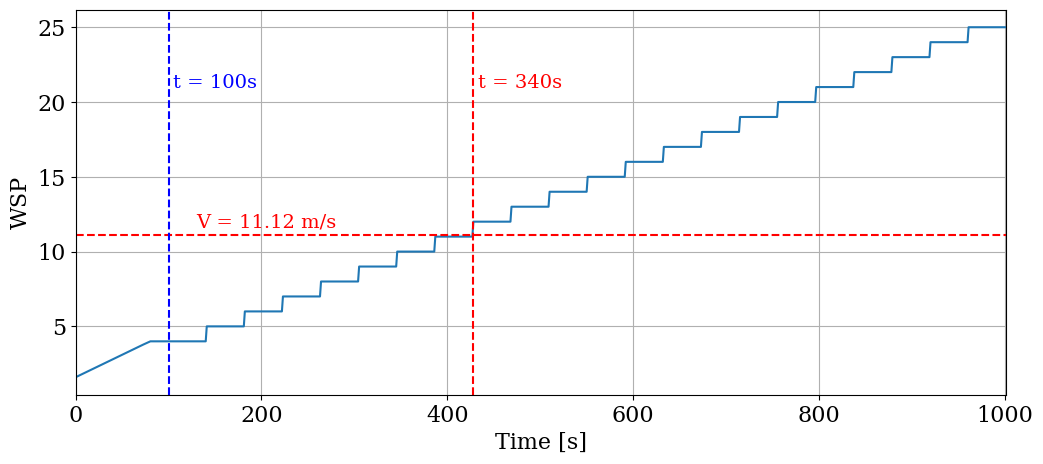

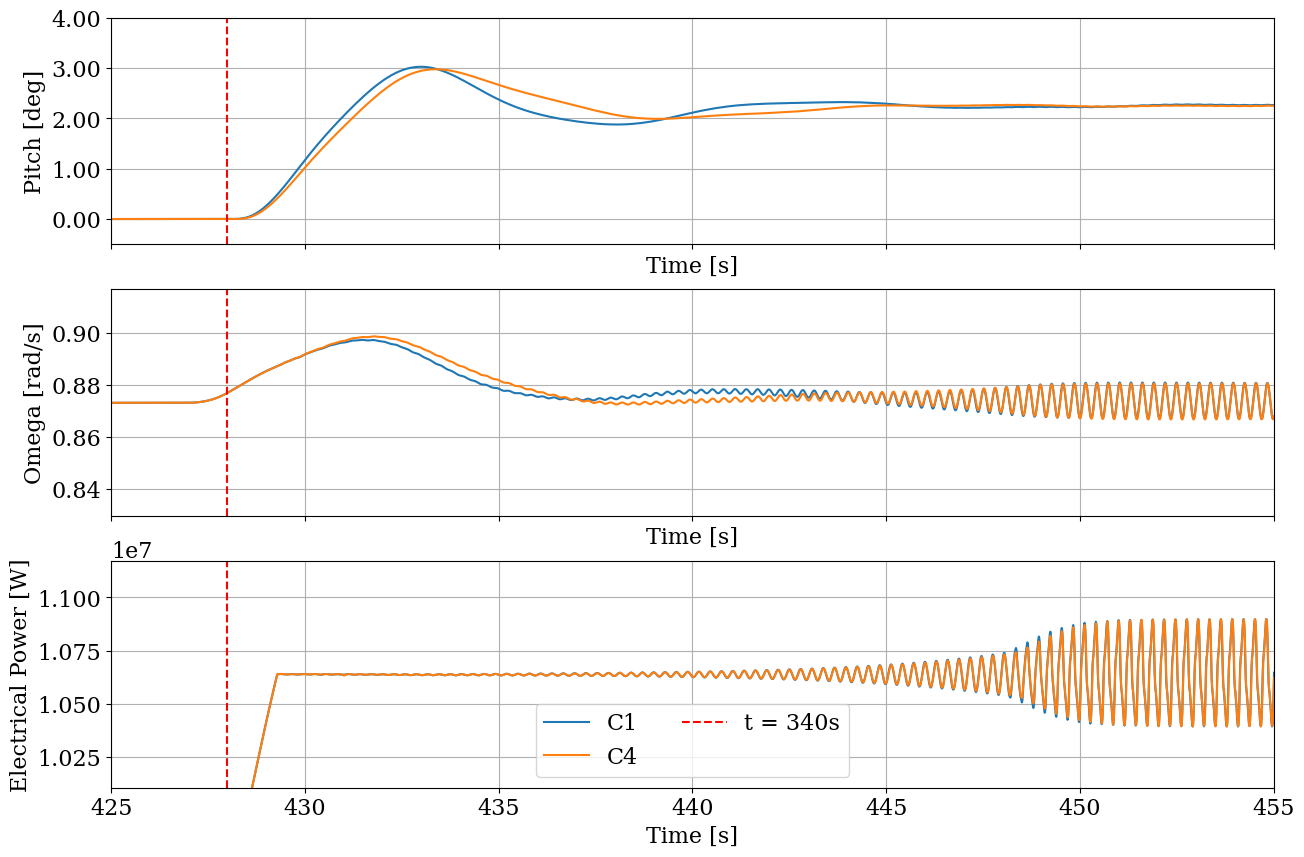

In [103]:
# additional plots


xmin = 0
xmax = 1001
vertical_line_time = 428
horizontal_line_wsp = V_RATED_Y
fontSize = 14


fig_wsp, ax_wsp = plt.subplots(figsize=(12, 5))

k = 1
# Filename for each iteration
fname = f'our_design/res/Group1_redesign_hawc2s_step_C{k}.hdf5'
h2res = ReadHAWC2(fname)

# Retrieve channel information
names, units, desc = h2res.chaninfo

# Extract indices for time, WSP, Omega, pitch, and power
idx_Time = np.where(['Time' in name for name in names])[0]
idx_WSP = np.where(['WSP gl. coo.,Vy' in name for name in names])[0]

# Plot and set Y-limits for each axis
ax_wsp.plot(h2res.t, h2res.data[:, idx_WSP], label=f'WSP (C{k})')

# Add vertical line at t = 340s on each plot
ax_wsp.axhline(y=horizontal_line_wsp, color='red', linestyle='--', label=f'V = {V_RATED_Y:.2f}s')
ax_wsp.axvline(x=vertical_line_time, color='red', linestyle='--', label='t = 340s')
ax_wsp.axvline(x=100, color='b', linestyle='--', label='t = 100s')

# Add text annotations near the lines
ax_wsp.text(x=xmin + 130, y=horizontal_line_wsp + 0.5, s=f'V = {V_RATED_Y:.2f} m/s', color='red', fontsize=fontSize, ha='left')
ax_wsp.text(x=vertical_line_time + 5, y=ax_wsp.get_ylim()[1] * 0.8, s='t = 340s', color='red', fontsize=fontSize, ha='left')
ax_wsp.text(x=105, y=ax_wsp.get_ylim()[1] * 0.8, s='t = 100s', color='blue', fontsize=fontSize, ha='left')

# Set labels and titles for WSP plot
ax_wsp.set_xlabel('Time [s]')
ax_wsp.set_ylabel('WSP')
ax_wsp.set(xlim=[xmin, xmax])
ax_wsp.relim() 
ax_wsp.autoscale_view()
ax_wsp.grid()
#ax_wsp.legend()

fig_wsp.savefig('3_3_ws.pdf', format='pdf',bbox_inches='tight')      # Save WSP plot
plt.show(fig_wsp)





xmin = 425
xmax = 455
fig, (ax_pitch, ax_omega, ax_power) = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

k=1
# Filename for each iteration
fname = f'our_design/res/Group1_redesign_hawc2s_step_C{k}.hdf5'
h2res = ReadHAWC2(fname)

# Retrieve channel information
names, units, desc = h2res.chaninfo

# Extract indices for time, WSP, Omega, pitch, and power
idx_Time = np.where(['Time [s]' in name for name in names])[0]
idx_Omega = np.where(['Omega' in name for name in names])[0]
idx_pitch = np.where(['bea2 angle' in name for name in names])[0]
idx_power = np.where(['DLL inp   2:   2' in name for name in names])[0]

# Plot Pitch
ax_pitch.plot(h2res.t, h2res.data[:, idx_pitch[0]], label=f'Pitch (C{k})')

# Plot Omega
ax_omega.plot(h2res.t, h2res.data[:, idx_Omega], label=f'Omega (C{k})')

# Plot Power
ax_power.plot(h2res.t, h2res.data[:, idx_power], label=f'C{k}')

k=4
# Filename for each iteration
fname = f'our_design/res/Group1_redesign_hawc2s_step_C{k}.hdf5'
h2res = ReadHAWC2(fname)

# Retrieve channel information
names, units, desc = h2res.chaninfo

# Extract indices for time, WSP, Omega, pitch, and power
idx_Time = np.where(['Time [s]' in name for name in names])[0]
idx_Omega = np.where(['Omega' in name for name in names])[0]
idx_pitch = np.where(['bea2 angle' in name for name in names])[0]
idx_power = np.where(['DLL inp   2:   2' in name for name in names])[0]

# Plot Pitch
ax_pitch.plot(h2res.t, h2res.data[:, idx_pitch[0]], label=f'Pitch (C{k})')

# Plot Omega
ax_omega.plot(h2res.t, h2res.data[:, idx_Omega], label=f'Omega (C{k})')

# Plot Power
ax_power.plot(h2res.t, h2res.data[:, idx_power], label=f'C{k}')



ax_pitch.axvline(x=vertical_line_time, color='red', linestyle='--', label='t = 340s')
ax_omega.axvline(x=vertical_line_time, color='red', linestyle='--', label='t = 340s')
ax_power.axvline(x=vertical_line_time, color='red', linestyle='--', label='t = 340s')

# Set labels and titles for Pitch plot
ax_pitch.set_xlabel('Time [s]')
ax_pitch.set_ylabel('Pitch [deg]')
ax_pitch.set(xlim=[xmin, xmax])
ax_pitch.set(ylim=[-0.5, 4])
ax_pitch.yaxis.set_major_formatter(FormatStrFormatter('%3.2f'))  # Set y-ticks to 1 decimal
ax_pitch.grid()
#ax_pitch.legend(ncol=2)

# Set labels and titles for Omega plot
ax_omega.set_xlabel('Time [s]')
ax_omega.set_ylabel('Omega [rad/s]')
ax_omega.set(xlim=[xmin, xmax])
ax_omega.set(ylim=[OMEGA_MAX*np.pi/30*0.95, OMEGA_MAX*np.pi/30*1.05])
ax_omega.grid()
#ax_omega.legend(ncol=2)

# Set labels and titles for Power plot
ax_power.set_xlabel('Time [s]')
ax_power.set_ylabel('Electrical Power [W]')
ax_power.set(xlim=[xmin, xmax])
ax_power.set(ylim=[POWER_MAX*0.95, POWER_MAX*1.05])
ax_power.grid()
ax_power.legend(ncol=2)

# Save each figure to a file
#fig_omega.savefig('omega_plot_17.pdf')  # Save Omega plot
#fig_power.savefig('power_plot_17.pdf')  # Save Power plot
#fig_wsp.savefig('wsp_plot_17.pdf')      # Save WSP plot
#fig_pitch.savefig('pitch_plot_17.png')  # Save Pitch plot

# Show all plots
fig.savefig('3_3_14.pdf', format='pdf',bbox_inches='tight')
plt.show()
